Analyzing Recurring IT Incidents in NYC Systems

Step 1: Import libraries

In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import re

sns.set(style="whitegrid")

Step 2: Load 311 service requests (relational data via API)

In [10]:
url = "https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$limit=20000"
df311 = pd.read_csv(url)

# This ensures that required columns exist and types are correct
for col in ["created_date", "closed_date"]:
    if col not in df311.columns:
        df311[col] = pd.NaT

df311["created_date"] = pd.to_datetime(df311["created_date"], errors="coerce")
df311["closed_date"] = pd.to_datetime(df311["closed_date"], errors="coerce")

# Compute duration_hours safely
df311["duration_hours"] = (
    (df311["closed_date"] - df311["created_date"]).dt.total_seconds() / 3600
)

# Normalize categories
category_map = {"HEAT": "Heating", "HEAT/HOT WATER": "Heating", "PLUMBING": "Plumbing"}
df311["complaint_type"] = df311["complaint_type"].fillna("Unknown")
df311["category_norm"] = df311["complaint_type"].map(
    lambda x: category_map.get(str(x).upper(), str(x).title())
)

df311.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location,duration_hours,category_norm
0,67065095,2025-12-06 02:53:07,NaT,DSNY,Department of Sanitation,Graffiti,Graffiti,NaN,10467.0,3529 WHITEPLAINS ROAD,...,NaN,NaN,NaN,NaN,NaN,40.878178,-73.866023,"\n, \n(40.87817786685797, -73.86602282535466)",NaN,Graffiti
1,67066747,2025-12-06 02:51:10,NaT,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,10467.0,3488 WEBSTER AVENUE,...,NaN,NaN,NaN,NaN,NaN,40.878497,-73.871624,"\n, \n(40.87849712785142, -73.87162357991)",NaN,Graffiti
2,67068091,2025-12-06 02:06:12,NaT,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10466.0,655 EAST 230 STREET,...,NaN,NaN,NaN,NaN,NaN,40.891872,-73.860168,"\n, \n(40.89187241649303, -73.86016845296459)",NaN,Noise - Residential
3,67069952,2025-12-06 02:05:54,NaT,NYPD,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,10033.0,92 PINEHURST AVENUE,...,NaN,NaN,NaN,NaN,NaN,40.851539,-73.939096,"\n, \n(40.85153914538499, -73.93909644675512)",NaN,Illegal Parking
4,67068083,2025-12-06 02:05:22,NaT,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Store/Commercial,11206.0,894 BROADWAY,...,NaN,NaN,NaN,NaN,NaN,40.698003,-73.937080,"\n, \n(40.69800293380301, -73.93708011114347)",NaN,Noise - Commercial


Step 3: Scrape NYC OTI dashboard (Web page data)

In [11]:
status_url = "https://www.nyc.gov/content/oti/pages/"
html = requests.get(status_url).text
soup = BeautifulSoup(html, "html.parser")

incidents = []
for item in soup.find_all(["p", "li", "h2", "h3"]):
    text = item.get_text(strip=True)
    if text:
        tl = text.lower()
        if "network" in tl:
            category = "Network"
        elif "database" in tl:
            category = "Database"
        elif "application" in tl:
            category = "Application"
        elif "vendor" in tl:
            category = "Vendor"
        else:
            category = "General IT"

        incidents.append({
            "title": text[:50],
            "details": text,
            "category": category,
            "agency": "OTI",
            "created_at": pd.Timestamp.today()
        })

dfst = pd.DataFrame(incidents, columns=["title","details","category","agency","created_at"])

ROOT_CAUSE_MAP = {
    r"\bnetwork\b": "Network",
    r"\bdatabase\b": "Database",
    r"\bvendor\b": "Vendor",
    r"\bchange\b": "Change",
    r"\bapplication\b": "Application"
}
def tag_root_cause(text):
    for pattern, label in ROOT_CAUSE_MAP.items():
        if re.search(pattern, str(text), flags=re.IGNORECASE):
            return label
    return "Unspecified"

dfst["root_cause"] = dfst["details"].apply(tag_root_cause)

# Simulate SLA variation and use distinct column names to avoid collisions
rng = np.random.default_rng(seed=42)
dfst["web_duration_hours"] = rng.choice([24, 36, 48, 60, 72, 96], size=len(dfst))
dfst["web_sla_threshold_hours"] = dfst["category"].map(lambda c: 48 if c == "Network" else 72)
dfst["web_sla_breach"] = dfst["web_duration_hours"] > dfst["web_sla_threshold_hours"]

dfst.head()

,title,details,category,agency,created_at,root_cause,web_duration_hours,web_sla_threshold_hours,web_sla_breach
0,|,|,General IT,OTI,2025-12-07 05:38:23.738330,Unspecified,24,72,False
1,Office of Technology & Innovation,Office of Technology & Innovation,General IT,OTI,2025-12-07 05:38:23.738370,Unspecified,72,72,False
2,NYC 311,NYC 311,General IT,OTI,2025-12-07 05:38:23.738381,Unspecified,60,72,False
3,Search all NYC.gov,Search all NYC.gov,General IT,OTI,2025-12-07 05:38:23.738390,Unspecified,48,72,False
4,Main Menu,Main Menu,General IT,OTI,2025-12-07 05:38:23.738402,Unspecified,48,72,False


Step 4: Merging datasets by category and date

In [12]:
# Prepare merge keys
df311["date"] = df311["created_date"].dt.date
dfst["date"] = pd.to_datetime(dfst["created_at"]).dt.date

# Merge
merged = df311.merge(
    dfst,
    left_on=["category_norm", "date"],
    right_on=["category", "date"],
    how="left"
)

# Normalize agency columns
if "agency_x" in merged.columns:
    merged = merged.rename(columns={"agency_x": "agency_311"})
else:
    merged["agency_311"] = merged.get("agency", np.nan)

if "agency_y" in merged.columns:
    merged = merged.rename(columns={"agency_y": "agency_web"})

# SLA thresholds from 311 category; fallback to 48 if unknown
SLA_RULES = {"Heating": 48, "Plumbing": 72}
merged["sla_threshold_hours"] = merged["category_norm"].apply(lambda c: SLA_RULES.get(c, 48))

# Ensure duration columns exist and are numeric
merged["duration_hours"] = pd.to_numeric(merged.get("duration_hours", np.nan), errors="coerce")
merged["web_duration_hours"] = pd.to_numeric(merged.get("web_duration_hours", np.nan), errors="coerce")

# Combined duration: prefer 311 duration, else web duration
merged["duration_hours_combined"] = merged["duration_hours"].where(
    merged["duration_hours"].notna(), merged["web_duration_hours"]
)

# Compute unified breach flag
merged["sla_breach"] = merged["duration_hours_combined"] > merged["sla_threshold_hours"]

# Define plot_data here to ensure availability in Step 5
plot_data = merged.dropna(subset=["category_norm"]).copy()
plot_data["agency"] = plot_data["agency_311"].fillna(plot_data.get("agency_web"))

merged.head()

,unique_key,created_date,closed_date,agency_311,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,category,agency_web,created_at,root_cause,web_duration_hours,web_sla_threshold_hours,web_sla_breach,sla_threshold_hours,duration_hours_combined,sla_breach
0,67065095,2025-12-06 02:53:07,NaT,DSNY,Department of Sanitation,Graffiti,Graffiti,NaN,10467.0,3529 WHITEPLAINS ROAD,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,48,NaN,False
1,67066747,2025-12-06 02:51:10,NaT,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,10467.0,3488 WEBSTER AVENUE,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,48,NaN,False
2,67068091,2025-12-06 02:06:12,NaT,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10466.0,655 EAST 230 STREET,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,48,NaN,False
3,67069952,2025-12-06 02:05:54,NaT,NYPD,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,10033.0,92 PINEHURST AVENUE,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,48,NaN,False
4,67068083,2025-12-06 02:05:22,NaT,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Store/Commercial,11206.0,894 BROADWAY,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,48,NaN,False


Step 5: Aggregations and visualizations

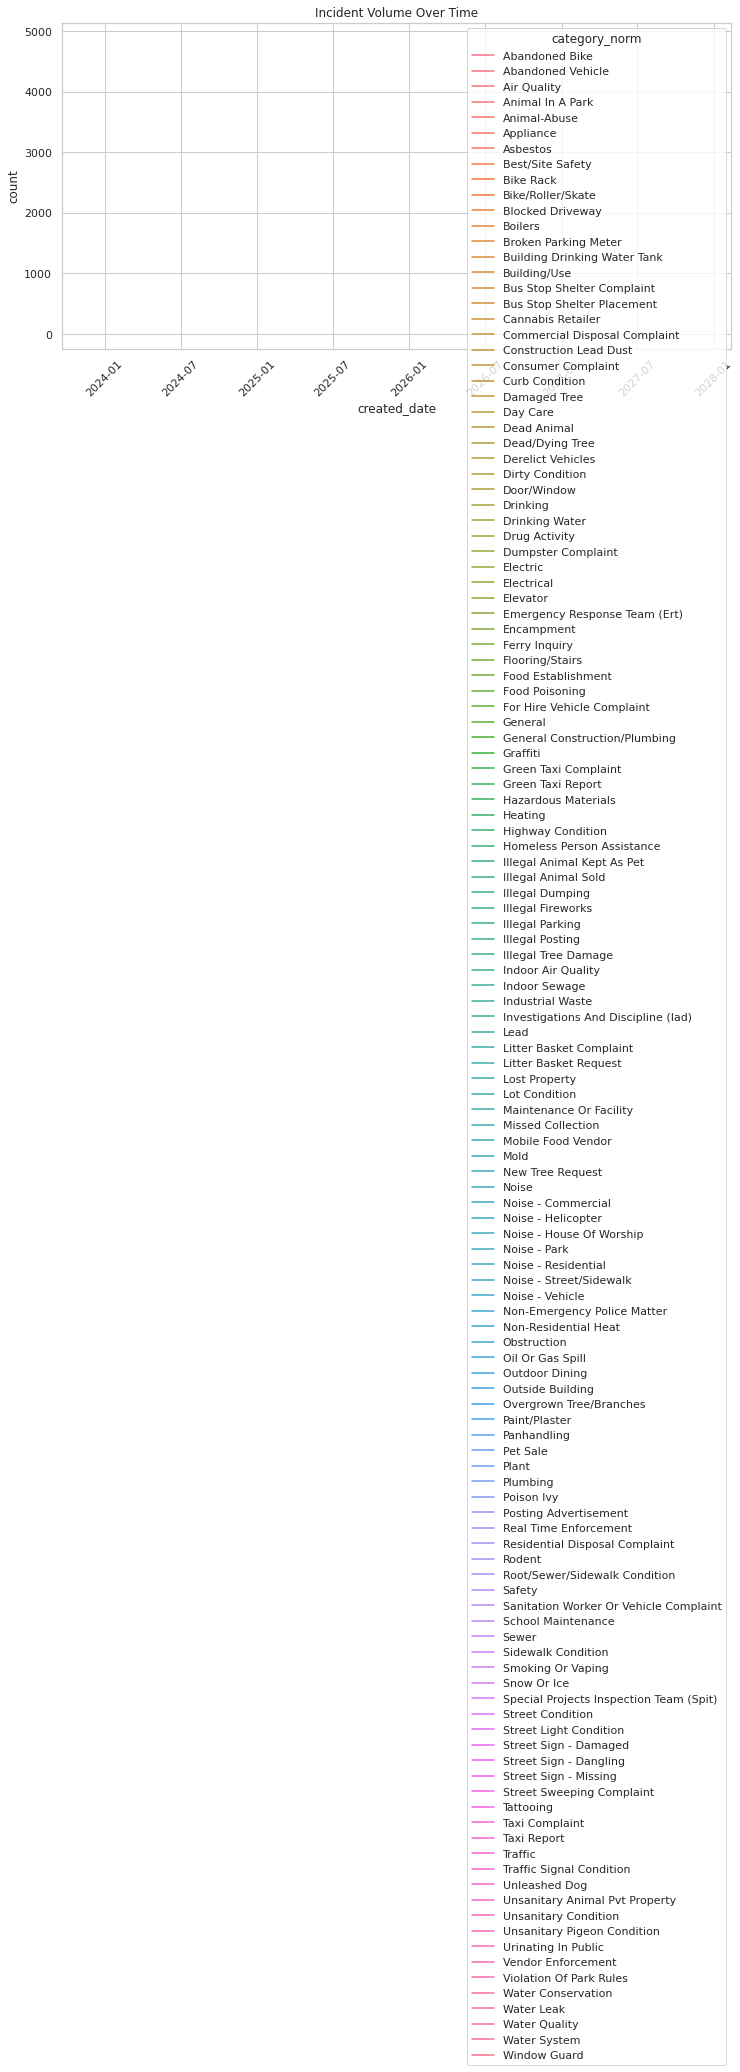

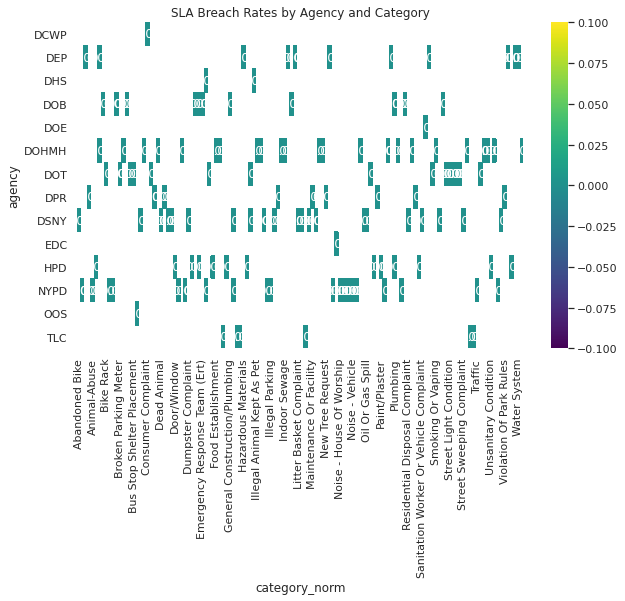

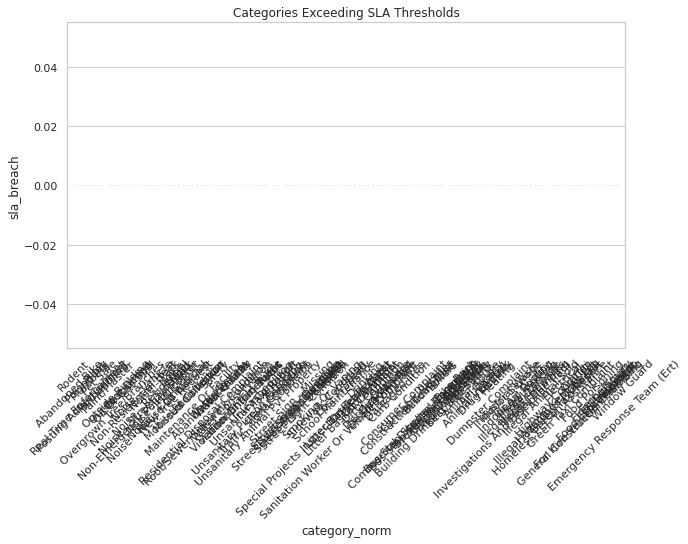

In [13]:
# Group metrics
grp = plot_data.groupby(["agency","category_norm"]).agg(
    incidents=("category_norm","size"),
    median_duration=("duration_hours_combined","median"),
    sla_breach_rate=("sla_breach","mean")
).reset_index()

# --- Line chart: Incident volume over time ---
ts = plot_data.groupby(
    [plot_data["created_date"].dt.to_period("M").dt.to_timestamp(), "category_norm"]
).size().reset_index(name="count")

plt.figure(figsize=(12,6))
sns.lineplot(data=ts, x="created_date", y="count", hue="category_norm")
plt.title("Incident Volume Over Time")
plt.xticks(rotation=45)
plt.show()

# --- Heatmap: SLA breach rates ---
pivot = grp.pivot(index="agency", columns="category_norm", values="sla_breach_rate")

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="viridis", annot=True, fmt=".2f")
plt.title("SLA Breach Rates by Agency and Category")
plt.show()

# --- Bar chart: Breach-prone categories ---
bar = plot_data.groupby("category_norm")["sla_breach"].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=bar, x="category_norm", y="sla_breach")
plt.title("Categories Exceeding SLA Thresholds")
plt.xticks(rotation=45)
plt.show()

Step 6: Chi-Square Test

In [14]:
cont = pd.crosstab(plot_data["category_norm"], plot_data["sla_breach"])

print("Contingency table:")
print(cont)

if cont.shape[0] > 1 and cont.shape[1] > 1:
    chi2, p, dof, expected = chi2_contingency(cont.values)
    print(f"\nChi-square={chi2:.2f}, p={p:.4f}, dof={dof}")
    print("\nExpected frequencies:")
    print(pd.DataFrame(expected, index=cont.index, columns=cont.columns))
else:
    print("\nNot enough variation in data for chi-square test.")
    print("Need at least 2 categories and both SLA breach states (True/False).")

Contingency table:
sla_breach          False
category_norm            
Abandoned Bike          5
Abandoned Vehicle     271
Air Quality            39
Animal In A Park       13
Animal-Abuse           69
...                   ...
Water Conservation      7
Water Leak            215
Water Quality           3
Water System          232
Window Guard            1

[130 rows x 1 columns]

Not enough variation in data for chi-square test.
Need at least 2 categories and both SLA breach states (True/False).


Conclusion: By combining the relational 311 data with scraped OTI dashboard updates, it was possible to: a. identify recurring incident categories. b. quantify SLA breach likelihood. c. tag root causes from qualitative updates. d. visualize systemic delays and breach-prone categories. By combining information from two different sources, this approach highlights practical findings that support stronger, forward‑looking IT management in NYC agencies.